In [1]:
# system
import os
import sys
import json
import gzip
from pathlib import Path

import collections

# data 
import numpy as np
import polars as pl
import geopandas as gpd
import anndata as ad
import scipy as sp
# import imageio # can remove this 
import tifffile 
from skimage.filters import threshold_otsu

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm 
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from adjustText import adjust_text
from pypalettes import load_cmap

In [2]:
seg_qc_path = "/ceph/cephatlas/aklein/SegQC/src"
sys.path.append(seg_qc_path)

In [3]:
# Testing 
# name = "region_R1"
# filepath_dir = "/ceph/cephatlas/aklein/bican/processed/202405211220_HuBrain-FF-UCSD-CP1403-A46-RC_VMSC00701_new/region_R1"
# transcripts_path = f"{filepath_dir}/detected_transcripts.parquet"
# image_path = f"{filepath_dir}/images"
# segmentation_mask = f"{filepath_dir}/cell_boundaries.parquet"


# # Experiment Path
# exp = "202504251055_BICAN-4x1-A46-01_VMSC31810"
# region = "region_UCI2424-A46-E"
# donor = "UCI2424"
# filepath_dir = f"/ceph/cephatlas/merscope_data/processed/202504251055_BICAN-4x1-A46-01_VMSC31810/out/{region}"
# transcripts_path = f"{filepath_dir}/detected_transcripts.parquet"
# image_path = f"{filepath_dir}/images"

# REN lab experiment
# Experiment Path
exp = "202503301431_20250330M190BICANRen25_VMSC32010"
region = "region_UCI2424Q04A9"
donor = "UCI2424"
filepath_dir = f"/ceph/cephatlas/merscope_data/processed/RenLab/{exp}/{region}"
transcripts_path = f"{filepath_dir}/detected_transcripts.parquet"
image_path = f"{filepath_dir}/images"


# For Default Vizgen segmentation : 
# seg_type="default"
# seg_mask_dir = f"/ceph/cephatlas/aklein/bican/data/segmented/{exp}/{seg_type}/{region}"
# cbg_path = f"{seg_mask_dir}/cell_by_gene.csv"
# cell_meta_path = f"{seg_mask_dir}/cell_metadata.csv"
# cell_poly_path = f"{filepath_dir}/cell_boundaries.parquet"
# tz_meta_path = transcripts_path

# # For the Proseg results
seg_type="proseg"
seg_mask_dir = seg_mask_dir = f"/ceph/cephatlas/aklein/bican/data/segmented/{exp}/{seg_type}/{region}"
cbg_path = f"{seg_mask_dir}/expected-counts.csv.gz"
cell_meta_path = f"{seg_mask_dir}/cell-metadata.csv.gz"

tz_meta_path = f"{seg_mask_dir}/transcript-metadata.csv.gz"
cell_poly_path = f"{seg_mask_dir}/cell-polygons-layers.geojson.gz"

# Classes

### stains class

In [ ]:
class Stains(): 
    """
    A class to handle image loading and processing.
    Specific to MERSCOPE image output format 

    attributes: 
        image_dir : the directory of the image merscope outputs for a given region
        scale : the scale at which to load the images 
    """
    def __init__(self, image_dir, scale:int=1):
        # args
        self.image_dir = image_dir
        self.image_scale = scale  
        # path files 
        self.transform_path = f"{self.image_dir}/micron_to_mosaic_pixel_transform.csv"
        self.manifest_path = f"{self.image_dir}/manifest.json"
        # Loading the images 
        self.image_dict = self.load_images()
        # Loading the additional information
        self.um_to_px, self.px_to_um = self._create_rescale_function(self.transform_path)
        self.bbox_microns = self._read_manifest(self.manifest_path)
    
    def load_images(self) -> collections.defaultdict:
        """
        Load all images in the directory
        """
        image_dict = collections.defaultdict(dict)

        image_files = list(Path(self.image_dir).glob('*.tif'))
        self.image_files = {f.stem.split('_')[1]: f for f in image_files}
        
        # load all images 
        for name, filepath in self.image_files.items():
            image = self._load_single_image(filepath, scale=self.image_scale)
            # save the image
            print(f"Loaded {name} with shape {image.shape}")
            image_dict[name] = image

        return image_dict
    
    # For loading a single stain image at a given scale 
    def _load_single_image(self, filepath, scale:int=1) -> np.array:
        # using tiffile to open image
        with tifffile.TiffFile(filepath) as tif: 
            page = tif.pages[0]
            height = page.imagelength
            width = page.imagewidth
            # calculating padding & shape based on scale
            pad_height = (scale - height % scale) % scale
            pad_width = (scale - width % scale) % scale
            # final shape of image to load
            shape = (height + pad_height) // scale, (width + pad_width) // scale
            # load the image
            stack = np.empty(shape, page.dtype)
            stack = page.asarray(out='memmap')[::scale, ::scale]
        return stack
        
    # For the micron mosaic transformation 
    def _create_rescale_function(self, filepath) -> tuple: 
        """

        """
        um_to_px = np.loadtxt(filepath)
        px_to_um = np.linalg.inv(um_to_px)
        return (um_to_px, px_to_um)

    # For getting bounding box of the image
    def _read_manifest(self, filepath) -> np.array: 
        """

        """
        with open(filepath, 'r') as f: 
            manifest = json.load(f)
        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = manifest['bbox_microns']
        return np.asarray([(bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax)])
    
    
    #
    def get_channels(self) -> list :
        """
        For getting a list of the available channels
        """
        return list(self.image_dict.keys())

    # 
    def get_image(self, image_name) -> np.array: 
        """
        Wrapper for _get_image to convert to numpy array (makes a deep copy)
        """
        return np.asarray(self._get_image(image_name))
    
    # 
    def _get_image(self, image_name) -> np.array : 
        """
        For Loading an image in memmap format
        """
        if image_name in self.image_dict.keys(): 
            return self.image_dict[image_name]
        else: 
            raise ValueError(f"""Image name not found in image dict. Image passes: {image_name}; Images available: {self.get_channels()} """)
        
    # 
    def image_total_intensity(self, image_name) -> int: 
        """
        Getting the total intensity of an image
        """ 
        return self._get_image(image_name).sum()
    
    def signal_to_noise_Z(self, image_name) -> float: 
        """
        The zscore signal to noise ratio is the ratio of the mean intensity to the std of intensity
        """
        img = self._get_image(image_name)
        return img.mean() / img.std()
    
    def signal_to_noise_Otsu(self, image_name) -> float: 
        """
        The Otsu signal to noise ratio is the mean intensity  above the otsu threshold to the mean intensity below it 
        """
        img = self._get_image(image_name)
        thr = threshold_otsu(img)
        return img[img > thr].mean() / img[img < thr].mean()
    
    # def signal_to_noise(self) -> collections.defaultdict: 
    #     res = collections.defaultdict(dict)
    #     for img_name in self.image_dict.keys(): 
    #         res[img_name] = {}
    #         res[img_name]['S/N - Z'] = self.signal_to_noise_Z(img_name)
    #         res[img_name]['S/N - O'] = self.signal_to_noise_Otsu(img_name)
    #     return res
    
    def _gen_single_stain_report(self, img_name) -> list: 
        """
        Generating a report (a list of values) for a single image
        -- ret order [stain, intensity, S/N Z, S/N O]
        """
        return [img_name,
                self.image_total_intensity(img_name),
                self.signal_to_noise_Z(img_name),
                self.signal_to_noise_Otsu(img_name),
            ]

    def gen_image_report(self):
        """
        Iterating over all images and generating the report for all of them
        """
        rep = []
        for img_name in self.image_dict.keys(): 
            rep.append(self._gen_single_stain_report(img_name))
        return pl.DataFrame(rep, schema=['Stain', 'Intensity', 'S/N - Z', 'S/N - O'], orient="row")
        
        
        

### Transcripts

In [ ]:
from SegQC.plotting import transcript_plots

# DEFS
X_LOC = "X_GLOBAL"
Y_LOC = "Y_GLOBAL"
Z_LOC = "Z_GLOBAL"
CELL_ID = "CELL_ID"
GENE_NAME = "GENE_NAME"
GENE_ID = "GENE_ID"
FOV_COL = "FOV"

MERSCOPE_PRESET = {"global_x":X_LOC,
                   "global_y":Y_LOC,
                   "global_z":Z_LOC,
                   "cell_id":CELL_ID,
                   "gene":GENE_NAME,
                   "transcript_id":GENE_ID,
                   "fov":FOV_COL,}
PROSEG_PRESET = {"x":X_LOC,
                 "y":Y_LOC,
                 "z":Z_LOC,
                 "assignment":CELL_ID,
                 "gene":GENE_NAME,
                 "transcript_id":GENE_ID,
                 "fov":FOV_COL,}

class Transcripts(): 
    def __init__(self, transcripts_path, file_orig="default"): 
        """
        Initializing a class to hold a transcripts object (either pre or post segmentation)
        attributes: 
            transcripts_path(str) : a path to the transcript file (either stores as csv or parquet)
            cell_id_col(str) : a string indicating the column name of the cell assignment is post segmentation
        """
        self.transcripts_path = transcripts_path
    
        if file_orig == "default":
            self.tr_df = self.read_transcripts(colname_mapper=MERSCOPE_PRESET)
        elif file_orig == "proseg":
            self.tr_df = self.read_transcripts(colname_mapper=PROSEG_PRESET)
    
    def get_transcripts(self) -> pl.DataFrame:
        """
        Get the transcript data.

        Returns:
            pl.DataFrame: A DataFrame containing the transcript data.
        """
        return self.tr_df
    
    def read_transcripts(self, colname_mapper:dict=MERSCOPE_PRESET,
                        ) -> pl.DataFrame: 
        """
        Read the transcript data from the specified path.

        attributes: 
            - the transformation between the column names in the file and the class standard

        Returns:
            pl.DataFrame: A DataFrame containing the transcript data.
            With the mapped gene names to the class standards
        """
        # colname_mapper = {xcol: X_LOC, ycol: Y_LOC, zcol: Z_LOC, cell_id_col: CELL_ID, gene_name_col: GENE_NAME, gene_id_col: GENE_ID, fov_col: FOV_COL}
        if self.transcripts_path.endswith('.csv') or self.transcripts_path.endswith('.csv.gz'):
            return pl.read_csv(self.transcripts_path).rename(colname_mapper)
        elif self.transcripts_path.endswith('.parquet'):
            return pl.read_parquet(self.transcripts_path).rename(colname_mapper)
        else:
            raise ValueError("Unsupported file format for transcripts. Please provide a .csv or .h5 file.")
        
    
    def calc_tr_cdf(self, plot=False):
        from sklearn.linear_model import LinearRegression
        tr_gene_vc = self.tr_df[GENE_NAME].value_counts()
        tr_gene_vc = tr_gene_vc.select(pl.col(GENE_NAME, "count").gather(pl.arg_sort_by("count")))
        
        # for the linear regression 
        Y = np.log(tr_gene_vc["count"].to_numpy())
        X = np.arange(len(Y)).reshape(-1, 1)
        model = LinearRegression().fit(X, Y)
        
        # for downstream calculations
        self.tr_gene_vc = tr_gene_vc
    
        # the R2 value
        return model.score(X, Y)    


    def calc_tr_balanced(self): 
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        from scipy.stats import gaussian_kde
        #  from scipy.stats import multivariate_normal
        
        tr_mean_pos = self.tr_df.group_by(GENE_NAME).agg(pl.col(X_LOC, Y_LOC).mean())
        self.tr_mean_pos = tr_mean_pos
        ss = StandardScaler()
        np_mean_pos = ss.fit_transform(tr_mean_pos[X_LOC, Y_LOC].to_numpy()).T
        cov_det = np.linalg.det(np.cov(np_mean_pos))
        return cov_det
        
    def calc_voxel_dist(self, roundto=10, filt_thr=10): 
        locs = self.tr_df.select(pl.col([X_LOC, Y_LOC]))
        locs = locs.with_columns(pl.col([X_LOC, Y_LOC])/roundto).cast(pl.Int32)
        voxel_dist = locs.group_by([X_LOC, Y_LOC]).len().select('len').to_numpy().flatten()
        voxel_dist = voxel_dist[voxel_dist > filt_thr]
        self.voxel_dist = voxel_dist
        return voxel_dist.mean(), voxel_dist.std(), voxel_dist.mean() / voxel_dist.std()

    
    def run_base_pipeline(self): 
        r2 = self.calc_tr_cdf()
        disp = self.calc_tr_balanced()
        vox_m, vox_s, vox_m2s = self.calc_voxel_dist()
        return [r2, disp, vox_m, vox_s, vox_m2s]
    
    def gen_transcripts_report(self): 
        return pl.DataFrame([self.run_base_pipeline()],
                            schema=['cdf_r2', 'dispersion', 'voxel_mean', 'voxel_std', 'voxel_S/N_Z'],
                            orient='row')

    def plot_base_pipeline(self, pdfFile=None, figsize=(15, 4)): 
        """
        attributes: 
            pdfFile(str) : if not None, save the figure to this pdf
        """
        # Make a plot: 
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=figsize)

        transcript_plots.plot_tr_cdf(self, regress=True, n_genes=3, ax=axes[0])
        transcript_plots.plot_tr_balance(self, scale=True, plot_PCA=False, ax=axes[1])
        transcript_plots.plot_voxel_dist(self, ax=axes[2])
        
        #pdfFile.close()
        if pdfFile:
            plt.savefig(pdfFile, bbox_inches="tight", dpi=300)
            plt.close()
        else:
            return fig, axes

    
    def tz_per_cell(self): 
        """
        For calculating the transcript per cell
        """
        tz = self.tr_df.group_by(CELL_ID).agg(pl.col(GENE_NAME).count())
        tz = tz.rename({GENE_NAME: "num_genes"})
        return tz
    
    def unique_tz_per_cell(self): 
        """
        For calculating the unique transcript per cell
        """
        tz = self.tr_df.group_by(CELL_ID).agg(pl.col(GENE_NAME).n_unique())
        tz = tz.rename({GENE_NAME: "num_unique_genes"})
        return tz

### Segmentation Masks

In [ ]:
# from plotting.segmentation import plot_feature_distribution

CELL_ID = "CELL_ID"
CELL_X = "CENTER_X"
CELL_Y = "CENTER_Y"
CELL_FOV = "fov"
CELL_VOLUME = "volume"

DEFAULT_PRESET = {"tz_cell_id": "cell", 
                  "meta_map" : {"EntityID" : CELL_ID,
                                "fov" : CELL_FOV,
                                "center_x" : CELL_X,
                                "center_y" : CELL_Y,
                                "volume" : CELL_VOLUME,
                                },                
                }
PROSEG_PRESET = {"tz_cell_id" : None,
                 "meta_map" : {"original_cell_id" : CELL_ID,
                                "fov" : CELL_FOV,
                                "centroid_x" : CELL_X,
                                "centroid_y" : CELL_Y,
                                "volume" : CELL_VOLUME,
                                },
                }
                 

class SegMask(): 
    """
    A class to handle the output of a segmentation algorithm 
    Not specific to a particular algorithm, however assumes some commonalities. 
    All outputs should have a cell by gene matrix, a cell metadata dataframe, and 
    a transcript dataframe with transcript to cell allocations

    attributes: 
        image_dir : the directory of the image merscope outputs for a given region
        scale : the scale at which to load the images 
    """
    def __init__(self, cell_by_gene_path:str, cell_meta_path:str=None,
                 seg_name:str="default", exp_name:str=None, reg_name:str=None, donor_name:str=None,
                 ):
        # args
        self.cbg_path = cell_by_gene_path
        self.meta_path = cell_meta_path
        
        # parameters for identifying the experiment
        self.seg_name = seg_name
        self.experiment = exp_name
        self.region = reg_name
        self.donor = donor_name
        self.load_preset(seg_name=seg_name)
        
        # load the cbg and cell meta dataframes
        self.cell_meta = self.load_cell_meta()
        self.cbg = self.load_cell_by_gene()


    def load_preset(self, seg_name:str="default"):
        """
        Load the preset for the segmentation algorithm
        """
        if seg_name == "proseg":
            self.preset = PROSEG_PRESET
        else:
            self.preset = DEFAULT_PRESET

    def load_cell_by_gene(self):
        #### TODO: add test cases
        """
        Load the cell by gene matrix 
        """
        cbg = pl.read_csv(self.cbg_path)
        if self.preset['tz_cell_id'] in cbg.columns:
            cbg = cbg.rename({self.preset['tz_cell_id']: CELL_ID})
        else: 
            cbg = cbg.with_columns(self.cell_meta.select(pl.col(CELL_ID)))
        return cbg
    
    def load_cell_meta(self):
        ### TODO: add test cases
        """
        Load the cell by gene matrix 
        """
        df_meta = pl.read_csv(self.meta_path)
        self.meta_columns = df_meta.columns
        self.num_cells = df_meta.shape[0]
        df_meta = df_meta.rename(self.preset['meta_map'])
        return df_meta
    
    def get_cell_by_gene(self) -> pl.DataFrame:
        """
        Get the cell by gene matrix
        """
        return self.cbg
    
    def get_cell_meta(self) -> pl.DataFrame:   
        """
        Get the cell metadata
        """
        return self.cell_meta
    
    def get_seg_name(self) -> str:
        """
        Get the segmentation name
        """
        return self.seg_name
    
    def add_class_info(self, df:pl.DataFrame) -> pl.DataFrame:
        """
        Add the class information
        """
        df = df.with_columns(
            experiment = pl.lit(self.experiment),
            segmentation = pl.lit(self.get_seg_name()),
            region = pl.lit(self.region),
            donor = pl.lit(self.donor),
        )
        df = df.with_columns(pl.concat_str([pl.col(CELL_ID),
                                            pl.col("experiment"),
                                            pl.col("region"),
                                            pl.col("segmentation"),
                                            ], separator=".").alias("Index"))
        return df
    
    def _get_cbg_feature(self) -> pl.DataFrame:
        """
        Get summary feature of the cell by gene matrix
        """
        # separating out the true genes from the blank counts 
        is_blank = (np.char.startswith(self.cbg.columns, "Blank-"))
        blank_data = self.cbg[:, is_blank]
        gene_data = self.cbg[:, ~is_blank]
    
        # calculating features 
        df_feature = gene_data.select(pl.exclude(CELL_ID)).sum_horizontal().to_frame()
        df_feature = df_feature.with_columns(self.cbg.select(pl.col(CELL_ID)))
        df_feature = df_feature.rename({"sum": "nCount_RNA"})
        df_feature = df_feature.with_columns(nFeature_RNA=(self.cbg.select(pl.exclude(CELL_ID)) != 0).sum_horizontal())
        df_feature = df_feature.with_columns(blank_data.sum_horizontal().alias("nBlank"))
        # adding general info 
        df_feature = self.add_class_info(df_feature)
        return df_feature
    
    def _get_meta_feature(self) -> pl.DataFrame:
        """
        Get summary feature of the cell metadata
        """
        df_feature = self.cell_meta.select([CELL_ID, CELL_X, CELL_Y, CELL_FOV, CELL_VOLUME])
        df_feature = self.add_class_info(df_feature)
        return df_feature

    def get_features(self) -> pl.DataFrame:
        """
        Get the features of the cell by gene matrix and cell metadata
        """
        df_join = self._get_cbg_feature().join(self._get_meta_feature(), on="Index", how="inner", coalesce=True)
        # Adding the count / volume ratio per cell 
        df_join = df_join.with_columns(pl.col("nCount_RNA").truediv(pl.col("volume")).alias("nCount_RNA_per_Volume"))
        # return a list of specific genes (info)
        return df_join.select(['Index', CELL_ID, "experiment", "region", "segmentation", CELL_X, CELL_Y, CELL_FOV, CELL_VOLUME,
                                'nCount_RNA', 'nFeature_RNA', 'nBlank', 'nCount_RNA_per_Volume'])
    
    # def plot_QC_metrics(self, pdfFile=None, **kwargs): 
    #     """
    #     Plot the QC metrics for the current segmentation
    #     """
    #     df_feature = self.get_features()

    def get_gene_cbg(self) -> pl.DataFrame: 
        """
        Get the cell by gene matrix
        """
        # separating out the true genes from the blank counts 
        is_blank = (np.char.startswith(self.cbg.columns, "Blank-"))
        gene_data = self.cbg[:, ~is_blank]
        return gene_data
    
    def run_QC_filtering(self, 
                         volume_min=100, volume_max=4000, vol_max_mult=3, max_vol_by_median=True,
                         n_count_min=20, n_count_max=1000, 
                         n_gene_min=5, n_gene_max=1000,
                         n_blank_min=-1, n_blank_max=5,
                         ncpv_min_quantile=0.02, ncpv_max_quantile=0.98,
                         plot=True, pdfFile=None): 
        """
        Given the Cell by Gene and cell metadata matrix, run the standard QC algo, 
        """
        # Get the feature matrix
        df_feature = self.get_features()
        n_count_per_volume = df_feature['nCount_RNA_per_Volume'].to_numpy()

        # Calculate the filtering thresholds that are data dependent
        if max_vol_by_median: 
            volume_max = df_feature['volume'].median() * vol_max_mult
        qMax = np.quantile(n_count_per_volume, ncpv_max_quantile)
        qMin = np.quantile(n_count_per_volume, ncpv_min_quantile)
        n_count_per_volume_min = qMin
        n_count_per_volume_max = qMax

        # Apply the filtering 
        judge = df_feature.filter(
            pl.col("volume").is_between(volume_min, volume_max) & 
            pl.col("nCount_RNA").is_between(n_count_min, n_count_max) &
            pl.col("nFeature_RNA").is_between(n_gene_min, n_gene_max) &
            pl.col("nBlank").is_between(n_blank_min, n_blank_max) &
            pl.col("nCount_RNA_per_Volume").is_between(n_count_per_volume_min, n_count_per_volume_max)
            ).select(CELL_ID)

        df_feature = df_feature.with_columns(pl.col(CELL_ID).is_in(judge).alias("pass_qc"))

        # Plot the Filtering: 
        if plot: 
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8), constrained_layout=True)

            plot_feature_distribution(df_feature, feature="volume", feature_alias="Cell Volume",
                                    min_val=volume_min, max_val=volume_max, ax=axes[0][0])
            plot_feature_distribution(df_feature, feature="nCount_RNA", feature_alias="RNA Count",
                                    min_val=n_count_min, max_val=n_count_max, ax=axes[0][1])
            plot_feature_distribution(df_feature, feature="nFeature_RNA", feature_alias="Num Unique RNAs", 
                                    min_val=n_gene_min, max_val=None, ax=axes[0][2])
            plot_feature_distribution(df_feature, feature="nBlank", feature_alias="Blank Count", 
                                    min_val=None, max_val=n_blank_max, ax=axes[1][0]) 
            plot_feature_distribution(df_feature, feature="nCount_RNA_per_Volume", feature_alias="Transcripts Per Cell Size",
                                    min_val=n_count_per_volume_min, max_val=n_count_per_volume_max, ax=axes[1][1])
            plot_filt_cells(df_feature, ax=axes[1][2], title="Filtered Cells")
            plt.suptitle("QC_Summary - Exp %s; - Region %s; - Segmentation %s" %(self.experiment, self.region, self.seg_name))
            if pdfFile: 
                pdfFile.savefig(fig, bbox_inches="tight", dpi=300)
                plt.close()
            else: 
                plt.show()

        # Save the filtering Results: 
        self.qc_cells = judge

    def gen_adata(self) -> ad.AnnData:
        """
        Generate an AnnData object from the cell by gene matrix and cell metadata
        """
        # Get the cell by gene matrix
        cbg = self.get_gene_cbg()
        cbg = cbg.filter(pl.col(CELL_ID).is_in(self.qc_cells))
        
        # Get the cell metadata
        df_feature = self.get_features()
        df_feature = df_feature.filter(pl.col(CELL_ID).is_in(self.qc_cells))
        
        # Create the AnnData object
        adata = ad.AnnData(X=sp.sparse.csr_matrix(cbg.select(pl.exclude(CELL_ID)).to_numpy()),
                           obs=df_feature.to_pandas(),
                           var={"gene_name" : cbg.columns[1:]})
        adata.obs.set_index("Index", inplace=True)
        adata.var.set_index("gene_name", inplace=True)
        return adata
        
    def get_num_cells(self): 
        """
        Return the number of cells in the segmentation 
        """
        return self.num_cells
    
    def cell_image_fraction(self): 
        """
        Return the fraction of the image occupied by cells
        """
        # TODO:
        # Calculate total image volume 
        total_image_volume = 1
        total_cell_volume = self.cell_meta.select("volume").sum()
        return total_cell_volume / total_image_volume
    
    def shilouette_score(self): 
        """
        Calculate scores based on shilouette scores: 
        - Need to calculate clusters (KNN is the most straight forward w/ varying k values)
        - Over all K calculate a CV score + variance explained by first PC + shilouette score (from sklearn)
        """
        ### TODO 
        return (0)

    def tr_per_cell(self, plot=False): 
        """
        Calculate the average tz / cell 
        If plotting do the violin plot of the dist. 
        """
        ### TODO Code this in the Transcript Class
        # Add a case for if there is a background segmentation add that as well. 
        return 0 

    def cells_per_100(self, plot=False):
        """
        Calculate the numebr of cells per 100um squared 
        if plot also plot the dist. 
        """
        # TODO 
        return 0 

    def cell_size_sd(self):
        """
        Calculate the variation in cell sizes
        upper bounded at 1, which is same cell size
        """
        cell_volumes = self.cell_meta.select("volume")
        return 1 / (np.log(cell_volumes.std()).flatten() + 1)

### Plotting Classes

#### Stains

In [ ]:
def plot_table_on_ax(
        data:np.ndarray,
        rowLabels:list,
        colLabels:list,
        title:str="",
        rcolors:list=None,
        ccolors:list=None,
        ax=None,
        ):
    """
    Plot a table with the given data, row labels, and column labels.

    Parameters
    ----------
    data : np.ndarray
        The data to be plotted in the table.
    rowLabels : list
        The labels for the rows of the table.
    colLabels : list
        The labels for the columns of the table.
    title : str
        The title of the axes.
    rcolors : list, optional
        color for the rows, by default None
    ccolors : list, optional
        color for the cols, by default None
    ax : 
        the ax object to plot this on
    """
    # Make sure that the table is of a non-numeric str type
    if ax == None: 
        fig, ax = plt.subplots()

    # Add a table at the bottom of the axes
    the_table = ax.table(cellText=data,
                        rowLabels=rowLabels,
                        rowColours=rcolors,
                        rowLoc='right',
                        colColours=ccolors,
                        colLabels=colLabels,
                        loc='top')
    # Scaling is the only influence we have over top and bottom cell padding.
    # Make the rows taller (i.e., make cell y scale larger).
    the_table.scale(1, 1.5)
    # Hide axes
    ax = plt.gca()
    ax.axis("off")
    ax.axis('tight')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Add title
    ax.set_title(title)
    
    fig = plt.gcf()
    return (fig, ax) 

In [ ]:
### Testing Stains Plotting Functions 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from matplotlib.gridspec import GridSpec
from pypalettes import load_cmap


# For plotting an image
def plot_img(img, grid=True, flip=False, title:str="", ax=None): 
    if ax == None: 
        _, ax = plt.subplots(figsize=(15, 15))
    if flip: 
        img = np.flipud(img)
    ax.imshow(img,     
              vmin = np.percentile(img, 99)*0.01,
              vmax = np.percentile(img, 99)*1.1,
              cmap = sns.dark_palette("#bfcee3", reverse=False, as_cmap=True)
    )
    if grid:
        ax.grid(visible=True, which='both', axis='both', c='#fff', ls='--', lw=0.5)
    ax.set_title(title)
    
    plt.gca().set_aspect('equal')
    
    return ax

def plot_stains(stains:Stains, plot_report=False, pdfFile=None, cmap_name:str="Klein", 
                figsize=(15, 10)): 
    """
    A function for plotting all of the stains in a Stains object

    attributes: 
        stains - an object of type Stains
        plot_report - whether to plot the stats table from the report 
        pdfFile - if not None, then save the report to this pdf file
    """
    cmap = load_cmap(cmap_name)
    n_channels = stains.get_num_channels()

    ncols = 3
    nrows = int( (n_channels + 1)/ 3) + 1
    fig = plt.figure(figsize=figsize, layout="constrained")
    gs = GridSpec(ncols=ncols, nrows=nrows+1, figure=fig)

    for i, img_name in enumerate(stains.get_channels()):
        color = cmap.colors[i]
        img = stains.get_image(img_name)
        ax = fig.add_subplot(gs[int(i / 3), int(i % 3)])
        ax = plot_img(img, grid=False, ax=ax)
        ax.set_title(img_name, color=color, size=20)

    if plot_report: 
        # Getting the report 
        df_report = stains.gen_image_report()
        cols = df_report.columns
        rows = df_report.select('Stain').to_numpy().flatten()
        data = df_report.select(cols).to_numpy()
        rcolors = cmap.colors[:len(rows)]

        def fmt_string(x): 
            return [a if type(a) == str else "{:.3E}".format(a) for a in x]
        data = np.apply_along_axis(fmt_string, axis=1, arr=data)
        
        axb = fig.add_subplot(gs[nrows - 1, :])
        axb = plot_table_on_ax(data, rows, cols, title="",rcolors=rcolors, ax=axb)

        if pdfFile: 
            pdfFile.savefig(fig)
        
    return fig


#### Transcripts

In [ ]:
# Transcript Plotting Functions 

X_LOC = "X_GLOBAL"
Y_LOC = "Y_GLOBAL"
Z_LOC = "Z_GLOBAL"
CELL_ID = "CELL_ID"
GENE_NAME = "GENE_NAME"
GENE_ID = "GENE_ID"
FOV_COL = "FOV"

def plot_voxel_dist(Tr:Transcripts, pdfFile=None, ax=None): 
    """
    attributes: 
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """
    if ax is None: 
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

    sns.histplot(Tr.voxel_dist, ax=ax)
    ax.set_title("Distribution of Transcript Density in voxels of 10 pixels^2")
    ax.set_xlabel("Number of Transcripts")
    return ax


def plot_tr_balance(Tr:Transcripts, scale=True, plot_PCA=False, pdfFile=None, ax=None): 
    """
    attributes: 
        scale(bool) : whether to scale the data (zscore it)
        plot_PCA(bool)
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from scipy.stats import gaussian_kde

    def makeColors(vals): 
        colors = np.zeros((len(vals), 3))
        norm = Normalize(vmin=vals.min(), vmax = vals.max())
        colors = [cm.ScalarMappable(norm=norm, cmap='jet').to_rgba(val) for val in vals]
        return colors
    
    if scale: 
        ss = StandardScaler()
        np_mean_pos = ss.fit_transform(Tr.tr_mean_pos[X_LOC, Y_LOC].to_numpy()).T
    else: 
        np_mean_pos = Tr.tr_mean_pos[X_LOC, Y_LOC].to_numpy().T
    
    denseObj = gaussian_kde(np_mean_pos)
    cc = makeColors(denseObj.evaluate(np_mean_pos))

    if ax is None: 
        fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    ax.scatter(np_mean_pos[0], np_mean_pos[1], s=1, color=cc)

    if plot_PCA:
        pca = PCA(n_components=2).fit(np_mean_pos)
        for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
            ax.plot([0, comp[0]], [0, comp[1]], label=f'C{i}, var:{var:.2f}',
                    color=f'C{i+2}', alpha=0.5)
        plt.legend()

    ax.set_title("Mean transcript position")
    ax.set_xlabel(X_LOC)
    ax.set_ylabel(Y_LOC)

    # calculating the density of each point and filtering the least dense points 
    density_scores = denseObj.evaluate(np_mean_pos)
    thr = np.percentile(density_scores, 1)
    to_label = np.where(density_scores < thr)[0]

    # getting the plot positions and gene names to plot
    x_pos, y_pos = np_mean_pos[:, to_label]
    text = Tr.tr_mean_pos.with_row_index().filter(pl.col("index").is_in(to_label)).select(GENE_NAME).to_numpy().flatten()

    red_c = load_cmap("Abbott").colors[0]
    texts = []
    for x, y, t in zip(x_pos, y_pos, text): 
        texts.append(ax.text(x, y, t, ha="center", va="center", c=red_c))

    adjust_text(texts, ax=ax)
    return ax

def plot_tr_cdf(Tr, regress = True, n_genes = 3, pdfFile=None, ax=None): 
    """
    attributes:
        regress(bool) : whether to plot the regression line
        n_genes(int) : the number of genes to plot
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """
    from sklearn.linear_model import LinearRegression

    # for the linear regression 
    Y = np.log(Tr.tr_gene_vc["count"].to_numpy())
    X = np.arange(len(Y)).reshape(-1, 1)
    model = LinearRegression().fit(X, Y)
    R2 = model.score(X, Y)
    pred = model.predict(X)

    if ax is None: 
        fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.scatter(np.arange(Tr.tr_gene_vc.shape[0]), Tr.tr_gene_vc['count'].to_numpy(), color='blue', s=1)
    ax.plot(np.arange(Tr.tr_gene_vc.shape[0]), np.exp(pred), color='red')

    # Getting text
    text = list(Tr.tr_gene_vc.head(n_genes).select(GENE_NAME).to_numpy().flatten())
    text.extend(list(Tr.tr_gene_vc.tail(n_genes).select(GENE_NAME).to_numpy().flatten()))
    # Getting the positions for the text
    x = [a[0]+1 for a in X[:n_genes]]
    y = [np.exp(a) for a in Y[:n_genes]]
    x.extend([a[0] for a in X[-n_genes:]])
    y.extend([np.exp(a) for a in Y[-n_genes:]])

    red_c = load_cmap("Abbott").colors[0]
    texts = []
    for xl, yl, t in zip(x, y, text): 
        texts.append(ax.text(xl, yl, t, ha='center', va='center', c=red_c))

    ax.set_title("Transcript Sorted Counts (R2: %.3f)" % R2)
    ax.set_yscale("log")
    ax.set_ylabel("Number of transcripts (log scale)")
    ax.set_xlabel("Gene ID")

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color=red_c, lw=0.5),
                expand=(1.5, 1.5),  expand_axes=True, force_statis=0.5, ax=ax,
                )
    return ax

#### Segmentation 

In [ ]:
def plot_feature_distribution(df:pl.DataFrame, feature:str, feature_alias:str=None, min_val=None, max_val=None,
                              num_bins:int=100, pdfFile=None, ax=None): 
    """
    attributes: 
        feature(str) : the feature to plot
        feature_alias(str) : the name to plot for the feature
        min_val(float) : the minimum value for the feature
        max_val(float) : the maximum value for the feature
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """
    if ax is None: 
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

    sns.histplot(df[feature].to_numpy(), bins=num_bins, ax=ax)
    if min_val: 
        ax.axvline(min_val, color='red', linestyle='--')
    if max_val: 
        ax.axvline(max_val, color='red', linestyle='--')

    ax.set_title(f"{feature} Distribution")
    if feature_alias: 
        ax.set_title(f"{feature_alias} Distribution")

    ax.set_xlabel(feature)
    return ax

def plot_filt_cells(df_feature:pl.DataFrame, title="", pdfFile=None, ax=None): 
    """
    attributes: 
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """
    filt_palette = {True : "#507B58", False : "#540202"}
    if ax is None: 
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

    # Plotting the filtered cells
    CELL_X = "CENTER_X"
    CELL_Y = "CENTER_Y"
    sns.scatterplot(ax=ax, data=df_feature, x=CELL_X, y=CELL_Y, hue='pass_qc', s=1, palette=filt_palette)
    ax.set_aspect('equal')
    ax.set_title(title)
    return ax

def plot_cell_density_distribution(df:pl.DataFrame, pdfFile=None, ax=None): 
    """
    attributes:
        pdfFile(str) : if not None, save the figure to this pdf
        ax(Matplotlib.Axes) : if not None, plot the figure on this ax
    """

    # Datashader option 
    import datashader as ds
    import colorcet

    density = df_feature.select([CELL_X, CELL_Y]).to_pandas()
    cvs = ds.Canvas(plot_width=900, plot_height=900)
    agg = cvs.points(density, CELL_X, CELL_Y)
    img = ds.tf.shade(agg, cmap=colorcet.dimgray, how="eq_hist")

    fig, ax = plt.subplots(figsize=(10,10), facecolor='white')
    ax.imshow(img.to_pil(),  extent=[density[CELL_X].min(), density[CELL_X].max(),
                                    density[CELL_Y].min(), density[CELL_Y].max()])

    ax.axis('off')
    ax.set_title(f"Num Cells={density.shape[0]}")
    plt.show()

    ### 2D heatmap option 
    density = df_feature.select([CELL_X, CELL_Y]).to_numpy()
    heatmap, xedges, yedges = np.histogram2d(density[:, 0], density[:, 1], bins=200)
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            origin='lower', cmap='viridis')
    ax.set_title("Cell Density Distribution")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    plt.show()
    
    return ax

# Tests

#### stains test 

In [ ]:
ImageCl = Stains(image_path, scale=10)

channel_list = ImageCl.get_channels()
print(channel_list)

# SN_ratios = ImageCl.signal_to_noise()
# print(SN_ratios)

DAPI_img = ImageCl.get_image("DAPI")
print(DAPI_img.sum())

total_int = ImageCl.image_total_intensity("DAPI")
print(total_int)

df_report = ImageCl.gen_image_report()

In [ ]:
seg_qc_path = "/ceph/cephatlas/aklein/SegQC/src"
sys.path.append(seg_qc_path)
from aklein.SegQC.src.SegQC.plotting import table_plots
from pypalettes import load_cmap

In [ ]:
cols = df_report.columns
rows = df_report.select('Stain').to_numpy().flatten()
data = df_report.select(cols).to_numpy()

cmap = load_cmap("Klein")
rcolors = cmap.colors[:len(rows)]

def fmt_string(x): 
    return [a if type(a) == str else "{:.3E}".format(a) for a in x]
data = np.apply_along_axis(fmt_string, axis=1, arr=data)

In [ ]:
fig, ax = plt.subplots()
table_plots.plot_table_on_ax(data, rows, cols, title="test_stats",rcolors=rcolors,
                  ax=ax)

### stain plots

In [ ]:
# ImageCl = Stains(image_path, scale=50)
# DAPI_img = ImageCl.get_image("DAPI")
# PolyT_img = ImageCl.get_image("PolyT")
# GFAP_img = ImageCl.get_image("GFAP")

fig = plt.figure(figsize=(15, 10), layout="constrained")
gs = GridSpec(2, 3, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax = plot_img(PolyT_img, grid=False, ax=ax)
ax.set_title("PolyT", color="red", size=20)

ax = fig.add_subplot(gs[0, 1])
ax = plot_img(DAPI_img, grid=False, ax=ax)
ax.set_title("DAPI", color="blue", size=20)

ax = fig.add_subplot(gs[0, 2])
ax = plot_img(GFAP_img, grid=False, ax=ax)
ax.set_title("GFAP", color="green", size=20)

ax2 = fig.add_subplot(gs[1, :])
ax2 = plot_table_on_ax(data, rows, cols, title="",rcolors=rcolors, ax=ax2)

plt.show()

In [ ]:
fig = plot_stains(stains, plot_report=True, figsize=(15, 10))
plt.show(fig)

### Transcripts

In [ ]:
Tr = Transcripts(transcripts_path, file_orig="merscope")

In [ ]:
num_genes = Tr.tz_per_cell()['num_genes'].to_numpy()

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.histplot(num_genes, bins=100, ax=ax)
ax.set_title("Transcripts per Cell, mean= %.2f, median= %.2f" % (num_genes.mean(), np.median(num_genes)))
ax.set_xlabel("Number of Transcripts")
ax.set_ylabel("Number of Cells")
plt.show()

In [ ]:
num_unique_genes = Tr.unique_tz_per_cell()['num_unique_genes'].to_numpy()

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.histplot(num_unique_genes, bins=100, ax=ax)
ax.set_title("Unique Transcripts per Cell, mean= %.2f, median= %.2f" % (num_unique_genes.mean(), np.median(num_unique_genes)))
ax.set_xlabel("Number of Unique Transcripts")
ax.set_ylabel("Number of Cells")
plt.show()

In [ ]:
tr_df = Tr.get_transcripts()

In [ ]:
Tr.run_base_pipeline()

In [ ]:
fig, axes = Tr.plot_base_pipeline()
plt.show(fig)

In [ ]:
# merscope_preset = {"xcol":"global_x",
#                    "ycol":"global_y",
#                    "zcol":"global_z",
#                    "cell_id_col":"cell_id",
#                    "gene_name_col":"gene",
#                    "gene_id_col":"transcript_id",
#                    "fov_col":"fov"}

In [ ]:
# Testing naming convention of Proseg output
seg_mask_dir = "/ceph/cephatlas/aklein/bican/data/segmented/202504251055_BICAN-4x1-A46-01_VMSC31810/proseg/region_UCI2424-A46-E/"
tz_meta_path = f"{seg_mask_dir}/transcript-metadata.csv.gz"
# pl.read_csv(tz_meta_path).head(5)
Tr = Transcripts(tz_meta_path, file_orig="proseg")


In [ ]:
Tr.run_base_pipeline()

In [ ]:
fig, axes = Tr.plot_base_pipeline()
plt.show(fig)

In [ ]:
# Regression (gene rank vs. abundance) plots

from sklearn.linear_model import LinearRegression

tr_gene_vc = tr_df['gene'].value_counts()
tr_gene_vc = tr_gene_vc.select(pl.col("gene", "count").gather(pl.arg_sort_by("count")))


# for the linear regression 
Y = np.log(tr_gene_vc["count"].to_numpy())
X = np.arange(len(Y)).reshape(-1, 1)
model = LinearRegression().fit(X, Y)
R2 = model.score(X, Y)
pred = model.predict(X)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(np.arange(tr_gene_vc.shape[0]), tr_gene_vc['count'].to_numpy(), color='blue', s=1)
ax.plot(np.arange(tr_gene_vc.shape[0]), np.exp(pred), color='red')

# the number of genes to plot (from most and least expression )
n_genes = 3
# Getting text
text = list(tr_gene_vc.head(n_genes).select("gene").to_numpy().flatten())
text.extend(list(tr_gene_vc.tail(n_genes).select("gene").to_numpy().flatten()))
# Getting the positions for the text
x = [a[0]+1 for a in X[:n_genes]]
y = [np.exp(a) for a in Y[:n_genes]]
x.extend([a[0] for a in X[-n_genes:]])
y.extend([np.exp(a) for a in Y[-n_genes:]])

red_c = load_cmap("Abbott").colors[0]
texts = []
for xl, yl, t in zip(x, y, text): 
    texts.append(ax.text(xl, yl, t, ha='center', va='center', c=red_c))

ax.set_title("Transcript Sorted Counts (R2: %.3f)" % R2)
ax.set_yscale("log")
ax.set_ylabel("Number of transcripts (log scale)")
ax.set_xlabel("Gene ID")

adjust_text(texts, arrowprops=dict(arrowstyle="-", color=red_c, lw=0.5),
            expand=(1.5, 1.5),  expand_axes=True, force_statis=0.5,
            )
plt.show()

In [ ]:
# Transcripts per cell 

## Part of the with segmentation pipeline
tr_vc = df_transcripts['cell_id'].value_counts()
tot_tr_assigned = tr_vc.filter(pl.col('cell_id') == -1)['count'][0]
assign_ratio = tot_tr_assigned / df_transcripts.shape[0]
print(f"Total transcripts assigned to cells: {tot_tr_assigned} / {df_transcripts.shape[0]} ({assign_ratio:.2%})")

tr_vc = tr_vc.filter(pl.col('cell_id') != -1)
tr_per_cell_mean = tr_vc['count'].mean()
tr_per_cell_std = tr_vc['count'].std()
print(f"Mean transcripts per cell: {tr_per_cell_mean:.2f} +/- {tr_per_cell_std:.2f}")

# plot violin plot of transcript assignments: 
fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
sns.violinplot(y=tr_vc['count'].to_numpy(), color='blue', ax=ax)
ax.set_title("Transcripts per Cell (Pre QC)")
ax.set_ylabel("Number of transcripts")
ax.set_xlabel("")
plt.show()

In [ ]:
# Disperrsion Plots

from scipy.stats import gaussian_kde

# pypalettes example code
from pypalettes import load_cmap
cmap = load_cmap("Sunset2", cmap_type="continuous")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def makeColors(vals): 
    colors = np.zeros((len(vals), 3))
    norm = Normalize(vmin=vals.min(), vmax = vals.max())
    colors = [cm.ScalarMappable(norm=norm, cmap='jet').to_rgba(val) for val in vals]
    return colors


tr_mean_pos = df_transcripts.group_by("gene").agg(pl.col("global_x", "global_y").mean())
ss = StandardScaler()
np_mean_pos = ss.fit_transform(tr_mean_pos['global_x', 'global_y'].to_numpy()).T

denseObj = gaussian_kde(np_mean_pos)
cc = makeColors(denseObj.evaluate(np_mean_pos))

fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
# ax.scatter(tr_mean_pos['global_x'], tr_mean_pos['global_y'], s=1, color=cc)
ax.scatter(np_mean_pos[0], np_mean_pos[1], s=1, color=cc)

pca = PCA(n_components=2).fit(np_mean_pos)
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
    ax.plot([0, comp[0]], [0, comp[1]], label=f'C{i}, var:{var:.2f}',
            color=f'C{i+2}', alpha=0.5)

plt.gca().set(
    title = "Mean transcript position",
    ylabel = "global_y",
    xlabel = "global_x",
)

# calculating the density of each point and filtering the least dense points 
density_scores = denseObj.evaluate(np_mean_pos)
thr = np.percentile(density_scores, 1)
to_label = np.where(density_scores < thr)[0]

# getting the plot positions and gene names to plot
x_pos, y_pos = np_mean_pos[:, to_label]
text = tr_mean_pos.with_row_index().filter(pl.col("index").is_in(to_label)).select("gene").to_numpy().flatten()

texts = []
for x, y, t in zip(x_pos, y_pos, text): 
    texts.append(ax.text(x, y, t, ha="center", va="center", c=red_c))

adjust_text(texts, ax=ax)

plt.legend()
plt.show()

### Segmentation Masks 

In [ ]:
# For MERSCOPE: 
exp = "202504251055_BICAN-4x1-A46-01_VMSC31810"
region = "region_UCI2424-A46-E"
donor = "UCI2424"
seg_type="default"

seg_mask_dir = f"/ceph/cephatlas/aklein/bican/data/segmented/{exp}/{seg_type}/{region}"
cbg_path = f"{seg_mask_dir}/cell_by_gene.csv"
cell_meta_path = f"{seg_mask_dir}/cell_metadata.csv"


# For the Proseg results
seg_type="proseg"
seg_mask_dir = seg_mask_dir = f"/ceph/cephatlas/aklein/bican/data/segmented/{exp}/{seg_type}/{region}"
cbg_path = f"{seg_mask_dir}/expected-counts.csv.gz"
cell_meta_path = f"{seg_mask_dir}/cell-metadata.csv.gz"

# tz_meta_path = f"{seg_mask_dir}/transcript-metadata.csv.gz"

In [ ]:
# SM = SegMask(cell_by_gene_path=cbg_path, cell_meta_path=cell_meta_path, transcripts_path=tz_meta_path)
SM = SegMask(cell_by_gene_path=cbg_path, cell_meta_path=cell_meta_path, seg_name=seg_type, exp_name=exp, reg_name=region, donor_name=donor)

In [ ]:
# df_cbg = SM.get_cell_by_gene()
# cell_meta = SM.get_cell_meta()

# # Testing private methods
# # df_feature = SM._get_cbg_feature()
# # df_feature = SM._get_meta_feature()

# # combined features of segmentation 
# df_feature = SM.get_features()
# df_feature.head()

In [ ]:
SM.run_QC_filtering()

In [ ]:
adata = SM.gen_adata()
adata.obs.set_index("Index", inplace=True)
adata.var.set_index("gene_name", inplace=True)

In [ ]:
SM.cell_size_sd(), SM.get_num_cells()

In [3]:
# Experiment Path
exp = "202503301431_20250330M190BICANRen25_VMSC32010"
region = "region_UCI2424Q04A9"
donor = "UCI2424"

seg_type="proseg"
seg_mask_dir = seg_mask_dir = f"/ceph/cephatlas/aklein/bican/data/segmented/{exp}/{seg_type}/{region}"
cbg_path = f"{seg_mask_dir}/expected-counts.csv.gz"
cell_meta_path = f"{seg_mask_dir}/cell-metadata.csv.gz"

In [5]:
# Testing 
cbg = pl.read_csv(cbg_path)
cell_meta = pl.read_csv(cell_meta_path)
# tz_meta = pl.read_csv(tz_meta_path)

In [6]:
cell_polygon_path = f"{seg_mask_dir}/cell-polygons.geojson.gz"
with gzip.open(cell_polygon_path, 'rb') as f:
    gdf = gpd.read_file(f)
gdf['geometry'].bounds.max(), gdf['geometry'].bounds.min()

(minx    10349.0
 miny     7234.0
 maxx    10394.0
 maxy     7273.0
 dtype: float64,
 minx    1194.0
 miny     225.0
 maxx    1266.0
 maxy     273.0
 dtype: float64)

In [7]:
gdf.shape

(47457, 2)

# Main Class

In [4]:
# system
import os
import sys

# data 
import numpy as np
import polars as pl
import geopandas as gpd
import anndata as ad

# plotting
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

seg_qc_path = "/ceph/cephatlas/aklein/SegQC/src"
sys.path.append(seg_qc_path)
from SegQC.Stains import Stains
from SegQC.SegMask import SegMask
from SegQC.Transcripts import Transcripts
from SegQC.plotting import stain_plots, transcript_plots, segmentation_plots


class SpatialData(): 
    """
    A class for storing a spatial dataset and a segmentation mask.

    attributes: 
        transctripts : transcript location files (.csv / .parquet file)
        image : image files for intensity (.tif files)
        segmentation : a segmentation mask (.csv / .parquet file)
    """
    def __init__(self,
                 transcripts_path:str=None,
                 image_path:str=None,
                 reg_name:str=None,
                 exp_name:str=None, 
                 donor_name:str=None,
                 segmentation_path:str=None, # There is no really one path to segmentation object
                ): 
        """
        Initialize the SpatialData object with paths to the transcripts, image, and segmentation files.

        Args:
            reg_name (str) : The name of the region being analyzed
            transctripts_path (str): Path to the transcripts file.
            image_path (str): Path to the image files.
            segmentation_path (str): Path to the segmentation mask file.
        """
        self.reg_name=reg_name
        self.exp_name=exp_name
        self.donor_name=donor_name

        self.transcripts_path = transcripts_path
        self.image_path = image_path

        # self.segmentation_path = segmentation_path
    
    def load_images(self): 
        """
        Load the Stains object
        """
        self.stains = Stains(self.image_path, scale=10) # TODO change scale back to 1 once done with testing

    def load_transcripts(self):
        """
        Load the Transcripts object
        """
        self.transcripts = Transcripts(self.transcripts_path)

    def load_segmentation(self,
                          cell_by_gene_path:str,
                          cell_meta_path:str=None,
                          transcripts_path:str=None,
                          cell_polygons_path:str=None,
                          segmentation_type:str="default",
                          ):
        """
        Load the segmentation mask data.
        attributes: 
            cell_by_gene_path (str): Path to the cell by gene matrix file.
            cell_meta_path (str): Path to the cell metadata file.
            transcripts_path (str): Path to the transcripts file with annotated assignmets. 
                If this file is supplied it will override the existing Transcript object in this class
        """
        self.segmentation = SegMask(cell_by_gene_path=cell_by_gene_path,
                                    cell_meta_path=cell_meta_path,
                                    cell_polygons_path=cell_polygons_path,
                                    seg_name=segmentation_type,
                                    exp_name=self.exp_name,
                                    reg_name=self.reg_name,
                                    donor_name=self.donor_name,)
        if transcripts_path:
            self.transcripts = Transcripts(transcripts_path, file_orig=segmentation_type)
        
    def get_transcripts(self) -> pl.DataFrame:
        """
        Get the transcript data.

        Returns:
            pl.DataFrame: A DataFrame containing the transcript data.
        """
        return self.transcripts
    
    def get_segmentation(self) -> gpd.GeoDataFrame:
        """
        Get the segmentation mask data.

        Returns:
            pl.DataFrame: A DataFrame containing the segmentation mask data.
        """
        return self.segmentation
    
    def get_stains(self) -> Stains: 
        """
        Get the Stains object

        Returns:
            Stains: A Stains object with the images for this dataset
        """
        return self.stains
        
    def read_segmentation_mask(self) -> pl.DataFrame:
        """
        Read the segmentation mask data from the specified path.

        Returns:
            pl.DataFrame: A DataFrame containing the segmentation mask data.
        """
        if self.segmentation_path.endswith('.csv'):
            return gpd.read_csv(self.segmentation_path)
        elif self.segmentation_path.endswith('.parquet'):
            return gpd.read_parquet(self.segmentation_path)
        else:
            raise ValueError("Unsupported file format for segmentation mask. Please provide a .csv or .parquet file.")
        
    def run_presegmentation_report(self, 
                                   plot=False,
                                   pdf_path:str=None, 
                                   plot_report_table=False, 
                                   control_genes:list=None, 
                                   **kwargs):     
        # if pdf_path and not plot: 
        #     raise ValueError("If pdf_path is given, plot must be True")
        
        stains_report = self.stains.gen_image_report()
        tz_report = self.transcripts.gen_transcripts_report()
        
        if plot: 
            img_plot_fig = stain_plots.plot_stains(stains=self.stains, 
                                                reg_name = self.reg_name,
                                                plot_report = plot_report_table)
            tz_plot_fig, _ = stain_plots.plot_tz_report(Tr=self.transcripts, 
                                                    reg_name = self.reg_name, 
                                                    control_genes=control_genes)
            tz_pipeilne_plot_fig, _ = transcript_plots.plot_base_pipeline(self.transcripts, **kwargs)

            # if saving to a pdf
            if pdf_path: 
                pdf_file = PdfPages(pdf_path)
                pdf_file.savefig(img_plot_fig, bbox_inches="tight", dpi=300)
                pdf_file.savefig(tz_plot_fig, bbox_inches="tight", dpi=300)
                pdf_file.savefig(tz_pipeilne_plot_fig, bbox_inches="tight", dpi=300)
                pdf_file.close()
                plt.close(img_plot_fig)
                plt.close(tz_plot_fig)
                plt.close(tz_pipeilne_plot_fig)
    
            else: 
                # if not saving to the pdf, show the figures
                plt.show(tz_pipeilne_plot_fig)
                plt.show(tz_plot_fig)
                plt.show(img_plot_fig)
        
        return (stains_report, tz_report)
        # TODO: make the report a 2C polars table with "index" the category
    
    def run_QC_filtering(self, plot:bool=False, pdf_path:str=None, **seg_kwargs): 
        """
        # ## FILTERING PARAMETERS  Need to be passed in as args? 
            volume_min = 30
            max_vol_by_median = True
            vol_max_mult = 3
            volume_max = 4000
            # XZ had volume > 3 * median volume instead of this max value here
            n_count_min = 20 # 20
            n_count_max = 1000
            ncpv_min_quantile = 0.02
            ncpv_max_quantile = 0.98
            n_gene_min = 5 # 5
            n_blank_max = 5
        """
        fig, ax = self.segmentation.run_QC_filtering(plot=plot, **seg_kwargs)
        if plot: 
            if pdf_path: 
                pdf_file = PdfPages(pdf_path)
                pdf_file.savefig(fig, bbox_inches="tight", dpi=300)
                pdf_file.close()
                plt.close(fig)
            else: 
                plt.show(fig)        
                plt.close(fig) 
        adata = self.segmentation.gen_adata()
        return adata
        
    def run_segmentation_QC(self, post_filtering:bool = True) -> pl.DataFrame:
        """
        Generate a segmentation QC report (either pre / post filtering)
        """

        # generate more specific segmentation statistics
        df_stats = pl.DataFrame([[self.segmentation.get_num_cells(post_filtering),
                                  self.segmentation.cell_size_sd(post_filtering),
                                  self.transcripts.ratio_tz_in_cells(self.segmentation.qc_cells)],
                                  ['num_cells', '1/SD(cell_size)', '%_tz_in_cells']],
                                schema={"value":pl.Float64, "index":str})
        
        # Read in the features of the segmentation
        df_feats = self.segmentation.get_features(post_filtering=post_filtering)
        # generate descriptive statistics for each feature 
        df_desc = df_feats['nCount_RNA', 'nFeature_RNA', 'volume', 'nCount_RNA_per_Volume'].describe()
        df_desc = df_desc.filter(~pl.col("statistic").is_in(['count', 'null_count'])).unpivot(index="statistic")
        df_desc = df_desc.with_columns((pl.col("variable") + "-" + pl.col("statistic")).alias("index")).drop("statistic", "variable")
        
        # add the more general segmentation statistics
        df_desc = df_desc.vstack(df_stats)

        return df_desc
    

    def plot_fov(self, stain_name:str="DAPI", bbox:list=[3000,3000,3500,3500],
                 pdfFile:PdfPages=None, plot:bool=True, figsize=(15,15),**kwargs):
        """
        Plot the field of view for the specified stain.
        attributes: 
            stain_name (str): The name of the stain to plot.
            bbox (list): The bounding box for the field of view.
            scale_factor (int): The scale factor for the image.
            pdf_path (str): The path to save the PDF file.
            plot (bool): Whether to plot the figure or not.
        """

        img = self.stains.get_image(stain_name)
        # assert(bbox[0] >= 0, bbox[1] >= 0) 
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
        ax = stain_plots.plot_fov(img, bbox, ax=ax)
        ax = segmentation_plots.plot_cell_seg_fov(self.segmentation.get_cell_polygons(), mmpt=self.stains.um_to_px, 
                                                  bbox=bbox, scale_factor=self.stains.image_scale, ax=ax)
        ax.set_title(f"{self.reg_name} - {stain_name} - {self.segmentation.seg_name} - {bbox}")
        plt.gca().set_aspect('equal')
        if plot: 
            if pdfFile: 
                pdfFile.savefig(fig, bbox_inches="tight", dpi=300)
                plt.close(fig)
            else: 
                plt.show(fig)
                plt.close()

In [5]:
SP = SpatialData(transcripts_path=transcripts_path, image_path=image_path, reg_name=region, exp_name=exp)

In [8]:
SP.load_images()
SP.load_transcripts()
# SP.load_segmentation(cell_by_gene_path=cbg_path, cell_meta_path=cell_meta_path, cell_polygons_path=cell_poly_path,
#                      transcripts_path=tz_meta_path, segmentation_type=seg_type)

Loaded PolyT with shape (6907, 8755)
Loaded DAPI with shape (6907, 8755)
Loaded GFAP with shape (6907, 8755)


In [13]:
ref_list_json = "/ceph/cephatlas/aklein/bican/reference/ref.json"
with open(ref_list_json, 'r') as f:
    ref_list = json.load(f)

In [14]:
control_genes = ref_list['Cortex']['D2M2006']['control_genes']

(shape: (3, 4)
 ┌───────┬──────────────┬──────────┬────────────┐
 │ Stain ┆ Intensity    ┆ S/N - Z  ┆ S/N - O    │
 │ ---   ┆ ---          ┆ ---      ┆ ---        │
 │ str   ┆ i64          ┆ f64      ┆ f64        │
 ╞═══════╪══════════════╪══════════╪════════════╡
 │ PolyT ┆ 241034215428 ┆ 1.280577 ┆ 6712.42098 │
 │ DAPI  ┆ 99484939323  ┆ 0.716826 ┆ 9.244357   │
 │ GFAP  ┆ 292877409798 ┆ 1.136851 ┆ 4.080859   │
 └───────┴──────────────┴──────────┴────────────┘,
 shape: (1, 5)
 ┌─────────┬────────────┬────────────┬───────────┬─────────────┐
 │ cdf_r2  ┆ dispersion ┆ voxel_mean ┆ voxel_std ┆ voxel_S/N_Z │
 │ ---     ┆ ---        ┆ ---        ┆ ---       ┆ ---         │
 │ f64     ┆ f64        ┆ f64        ┆ f64       ┆ f64         │
 ╞═════════╪════════════╪════════════╪═══════════╪═════════════╡
 │ 0.98374 ┆ 0.868736   ┆ 79.035711  ┆ 64.011936 ┆ 1.234703    │
 └─────────┴────────────┴────────────┴───────────┴─────────────┘)

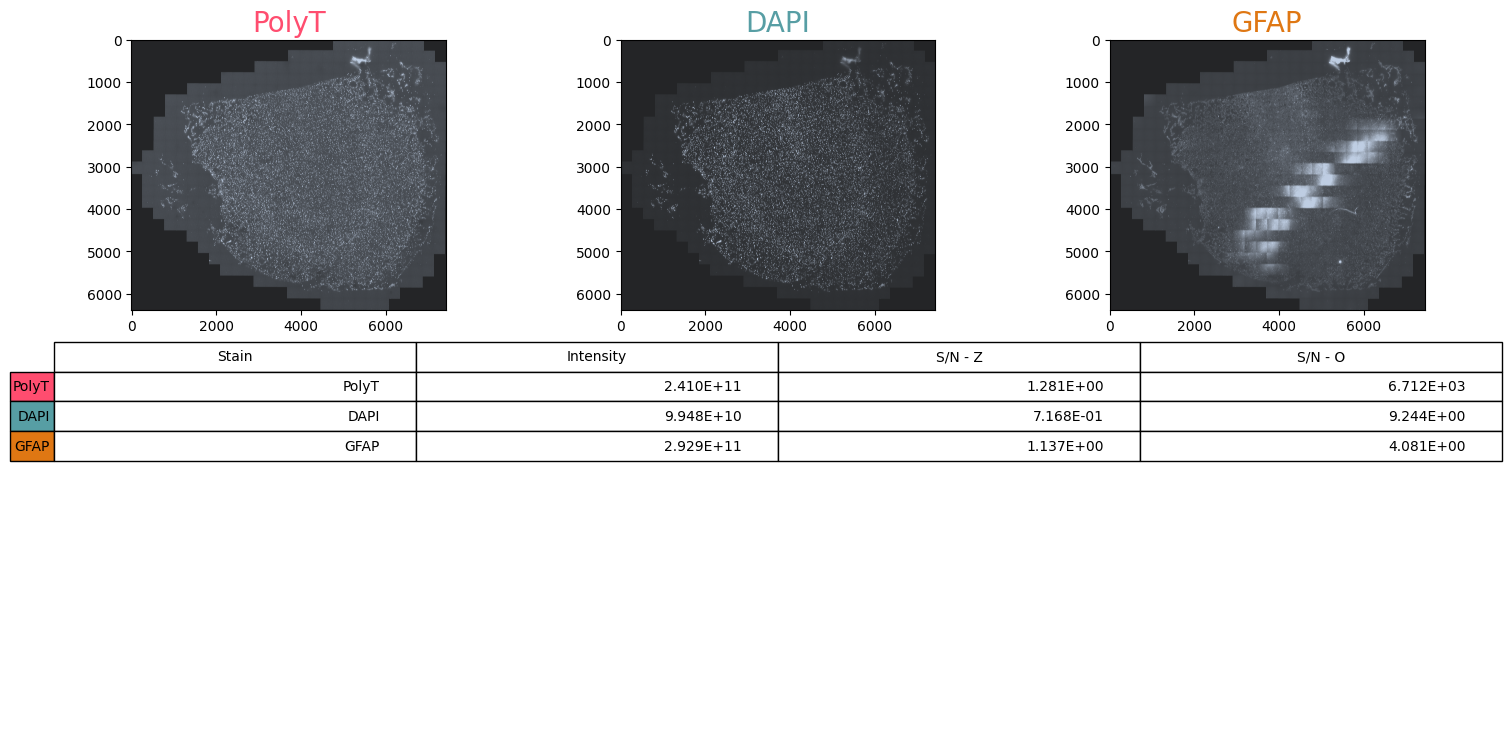

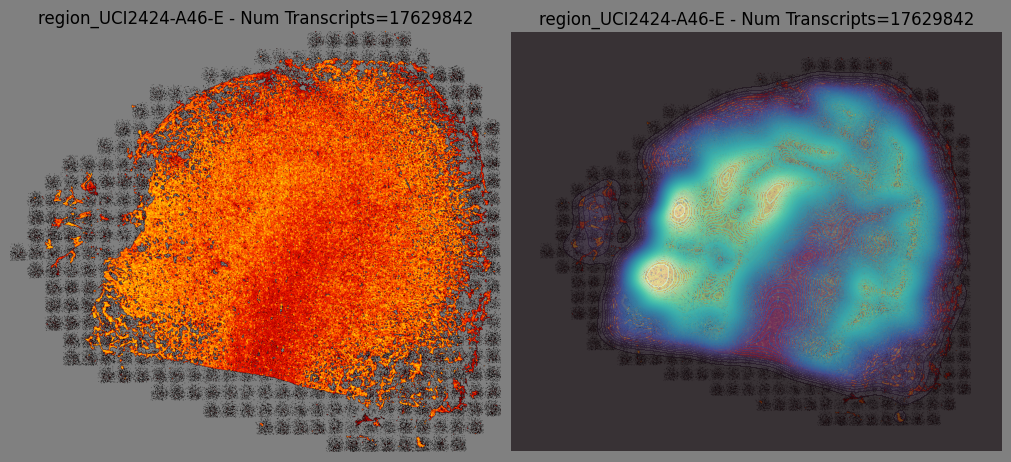

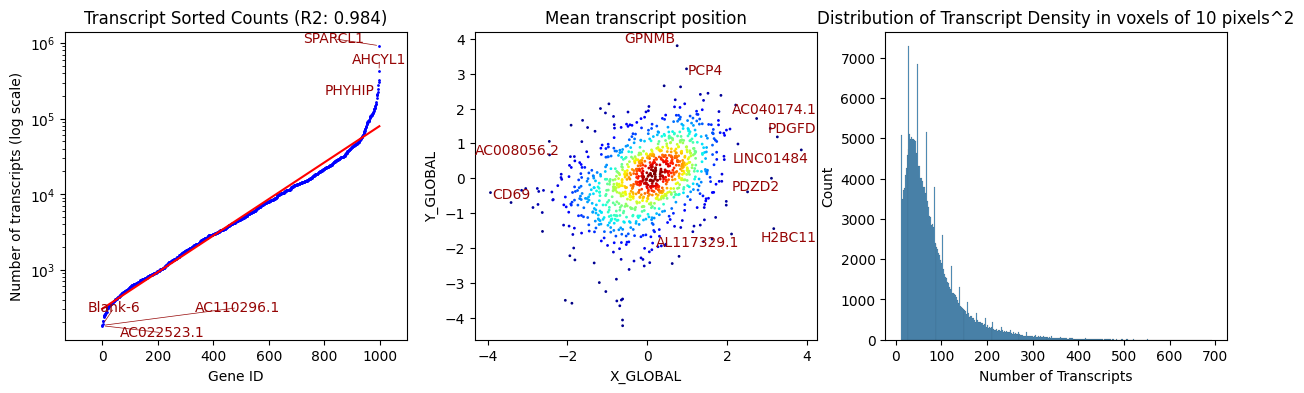

In [25]:
test_pdf_path = "/ceph/cephatlas/aklein/SegQC/tests/test.pdf"
SP.run_presegmentation_report(plot=True, control_genes=control_genes, pdf_path=test_pdf_path, plot_report_table=True)

In [26]:
seg_test_pdf_path = "/ceph/cephatlas/aklein/SegQC/tests/seg_test.pdf"
# SP.load_segmentation(cell_by_gene_path=cbg_path, cell_meta_path=cell_meta_path)
# SP.run_QC_filtering(plot=False, pdf_path=seg_test_pdf_path)
SP.run_QC_filtering(plot=False, pdf_path=None)

/ceph/cephatlas/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 27274 × 959
    obs: 'CELL_ID', 'experiment', 'region', 'segmentation', 'CENTER_X', 'CENTER_Y', 'fov', 'volume', 'nCount_RNA', 'nFeature_RNA', 'nBlank', 'nCount_RNA_per_Volume'

In [27]:
pp = SP.run_segmentation_QC(post_filtering=True)

/ceph/cephatlas/.venv/lib/python3.12/site-packages/polars/_utils/construction/series.py:316: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return constructor(name, values, strict)


In [ ]:
pp = pp.to_pandas().set_index("index").T
pp.index = []

index  nCount_RNA-mean  nCount_RNA-std  nCount_RNA-min  nCount_RNA-25%  \
value       208.117181      178.599275            20.0            75.0   

index  nCount_RNA-50%  nCount_RNA-75%  nCount_RNA-max  nFeature_RNA-mean  \
value           145.0           292.0           998.0         113.574467   

index  nFeature_RNA-std  nFeature_RNA-min  ...  nCount_RNA_per_Volume-mean  \
value         70.410626              12.0  ...                    0.138818   

index  nCount_RNA_per_Volume-std  nCount_RNA_per_Volume-min  \
value                   0.087514                   0.014439   

index  nCount_RNA_per_Volume-25%  nCount_RNA_per_Volume-50%  \
value                   0.062461                   0.120515   

index  nCount_RNA_per_Volume-75%  nCount_RNA_per_Volume-max  num_cells  \
value                   0.205335                   0.360582    27274.0   

index  1/SD(cell_size)  %_tz_in_cells  
value         0.133013       0.322839  

[1 rows x 31 columns]

In [6]:
# cell_poly_path = f"{seg_mask_dir}/cell-polygons-layers.geojson.gz"
cell_poly_path = f"{seg_mask_dir}/cell-polygons.geojson.gz"
SP.load_segmentation(cell_by_gene_path=cbg_path, cell_meta_path=cell_meta_path, cell_polygons_path=cell_poly_path,
                     segmentation_type=seg_type)

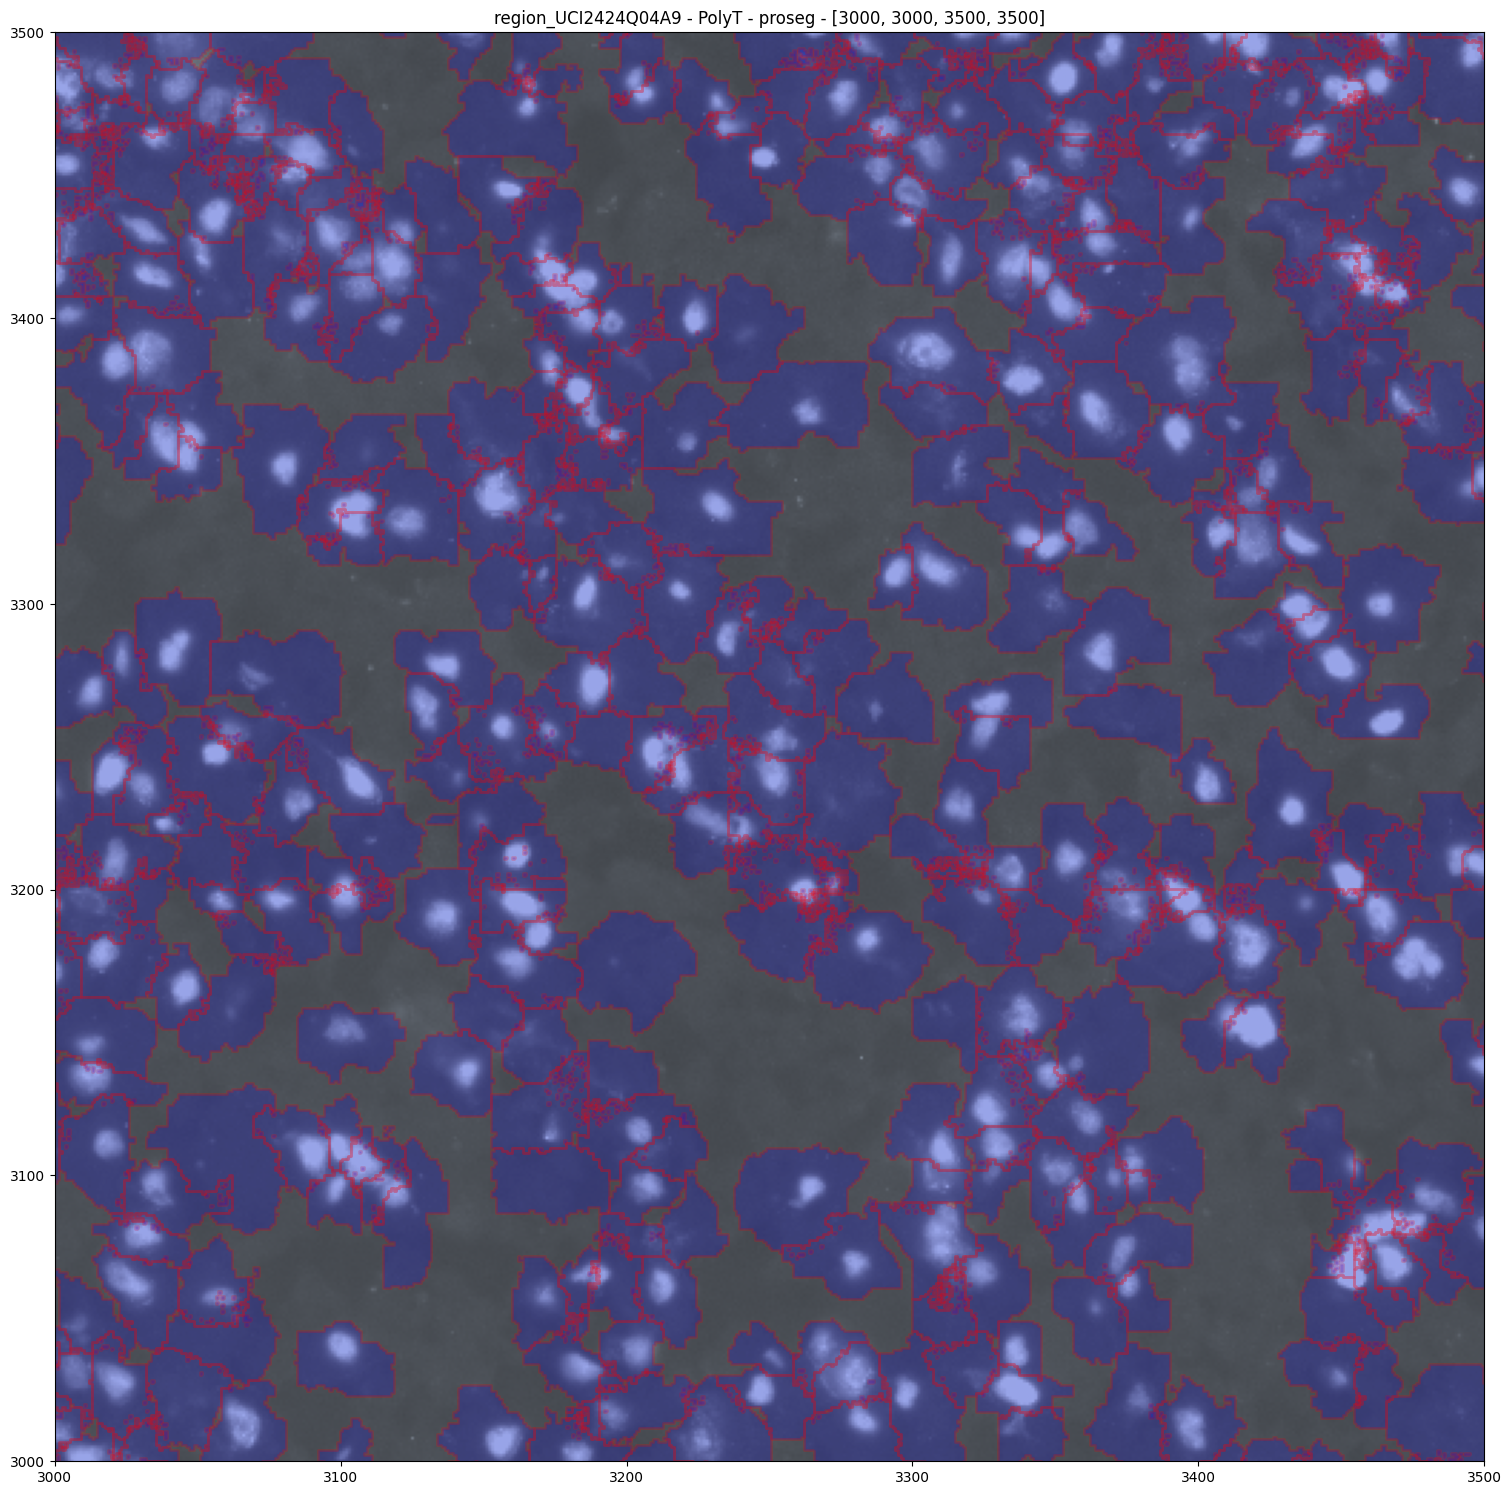

In [9]:
SP.plot_fov(stain_name="PolyT", bbox=[3000,3000,3500,3500], pdfFile=None, plot=True)

In [13]:
transcripts = SP.get_transcripts()
stains = SP.get_stains()
seg_mask = SP.get_segmentation()

In [27]:
# DEFS
X_LOC = "X_GLOBAL"
Y_LOC = "Y_GLOBAL"
Z_LOC = "Z_GLOBAL"
CELL_ID = "CELL_ID"
GENE_NAME = "GENE_NAME"
GENE_ID = "GENE_ID"
FOV_COL = "FOV"

In [14]:
img = stains.get_image("DAPI")

In [28]:
fovs = transcripts.tr_df[FOV_COL].unique().sample(10)
# stains.um_to_px

In [ ]:
cell_polygon_path = f"{seg_mask_dir}/cell-polygons-layers.geojson.gz"
with gzip.open(cell_polygon_path, 'rb') as f:
    gdf = gpd.read_file(f)
gdf['geometry'].bounds.max(), gdf['geometry'].bounds.min()

In [14]:
gdf.geometry

0         MULTIPOLYGON (((4347 3155, 4347 3156, 4348 315...
1         MULTIPOLYGON (((4347 3153, 4347 3154, 4349 315...
2         MULTIPOLYGON (((4346 3157, 4346 3158, 4347 315...
3         MULTIPOLYGON (((4347 3155, 4347 3159, 4348 315...
4         MULTIPOLYGON (((5890 1959, 5890 1957, 5891 195...
                                ...                        
127205    MULTIPOLYGON (((2608 5621, 2608 5622, 2607 562...
127206    MULTIPOLYGON (((4584 5946, 4584 5950, 4586 595...
127207    MULTIPOLYGON (((4586 5947, 4586 5946, 4587 594...
127208    MULTIPOLYGON (((4584 5967, 4584 5968, 4585 596...
127209    MULTIPOLYGON (((4586 5967, 4586 5968, 4585 596...
Name: geometry, Length: 127210, dtype: geometry

In [282]:
def_cp = gpd.read_parquet("/ceph/cephatlas/merscope_data/processed/202504251055_BICAN-4x1-A46-01_VMSC31810/out/region_UCI2424-A46-E/cell_boundaries.parquet")

In [240]:
def plot_fov(fov_shapes, fov_img, xmin, xmax, ymin, ymax): 
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(fov_img, 
            vmin = np.percentile(fov_img, 99)*0.05,
            vmax = np.percentile(fov_img, 99)*1.1,
            cmap = sns.dark_palette("#bfcee3", reverse=False, as_cmap=True),
            extent = [xmin, xmax, ymin, ymax]
            )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    fov_shapes.plot(facecolor="b", edgecolor='r', linewidth=2, alpha=0.2, ax=ax, aspect=1)
    plt.gca().set_aspect('equal')
    plt.show()

In [262]:
import shapely
mmpt = stains.um_to_px
scale_factor = stains.image_scale

In [ ]:
xmin = 3000; ymin = 3000; xmax = 3500; ymax=3500

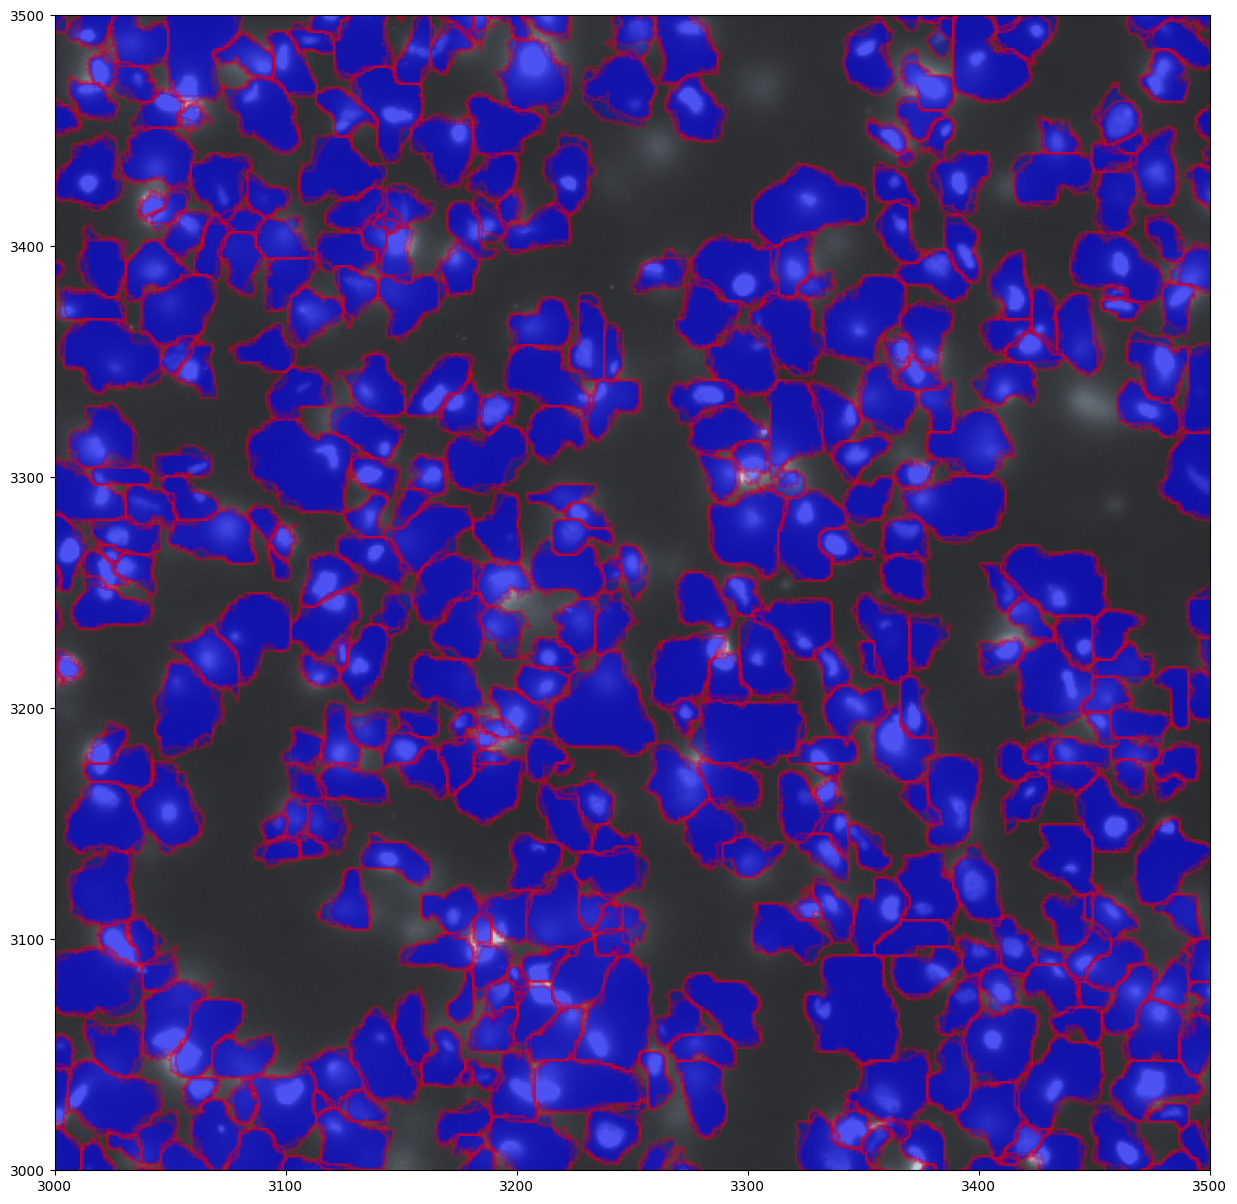

In [303]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img, 
        vmin = np.percentile(img, 99)*0.05,
        vmax = np.percentile(img, 99)*1.1,
        cmap = sns.dark_palette("#bfcee3", reverse=False, as_cmap=True),
        )

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# container = shapely.geometry.Polygon([(xmin-50, ymin-50), (xmax+50, ymin-50), (xmax+50, ymax+50), (xmin-50, ymax+50)])
container = shapely.geometry.Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
shapes = gdf['geometry'].apply(lambda x: shapely.affinity.affine_transform(x, [*mmpt[:2, :2].flatten(), *mmpt[:2, 2].flatten()]))
shapes = shapes.scale(xfact = 1/scale_factor, yfact = 1/scale_factor, zfact=1/scale_factor, origin=(0,0,0))
# shapes.plot(facecolor="b", edgecolor='r', linewidth=2, alpha=0.2, ax=ax, aspect=1)
fov_shapes = shapes.loc[shapes.intersects(container)]
fov_shapes.plot(facecolor="b", edgecolor='r', linewidth=2, alpha=0.2, ax=ax, aspect=1)


plt.gca().set_aspect('equal')
plt.show()

In [ ]:
stains.gen_image_report()

In [ ]:
stains.num_channels

In [ ]:
transcripts.run_base_pipeline()

In [ ]:
transcripts.plot_base_pipeline()